### Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from pandas import DataFrame
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load data

In [2]:
data_dir = "../../database_real/machine_learning_data/"
sentiment_data_dir="../../database/sentiment_data/data-result/"

In [3]:
import os
def merge_data(ticker):
    merge_path = os.path.join(data_dir,ticker.zfill(4)+'.HK_macd-crossover.csv') 
    sentiment_path = os.path.join(sentiment_data_dir,'data-'+ticker.zfill(5)+'-result.csv') 

    merge_df =pd.read_csv(merge_path,index_col='Date',usecols=['Date','signal','GDP','Unemployment rate','Property price','Close'],parse_dates=['Date'], na_values=['nan'])

    merge_df = merge_df.rename(columns={'signal': 'technical_signal'})
    sentiment_df =pd.read_csv(sentiment_path,index_col='dates',parse_dates=['dates'], na_values=['nan'])
    df=pd.merge(merge_df,sentiment_df, how='inner', left_index=True, right_index=True)
    return df
    


In [4]:
def visualization_data(df):
    # print(df)
    df.fillna(method='pad')
    df.plot(figsize=(20, 30), subplots=True);
    df.head()

In [5]:
def data_preprocess(df):
    df = df.fillna(method='ffill')
    values=df.values

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled= scaler.fit_transform(values)
    # print(scaled)
    return scaled,scaler


In [6]:
# function to create train, test data given stock data and sequence length
def load_data(data_raw, look_back):
    
    print(data_raw.shape)
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)   
    return x_train, y_train, x_test, y_test



In [7]:
def data_to_torch(x_train,y_train,x_test,y_test):
    # make training and test sets in torch
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    return x_train, y_train, x_test, y_test 


In [8]:
# y_train.size(),x_train.size()

### **Build model**

In [18]:
def create_model(x_train,y_train,x_test,y_test,input_dim,hidden_dim,num_layers,output_dim):
    batch_size = 32
    train = torch.utils.data.TensorDataset(x_train,y_train)
    test = torch.utils.data.TensorDataset(x_test,y_test)

    train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

    test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

    loss_fn = torch.nn.MSELoss()

    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    return model,loss_fn,optimiser

In [10]:
# Hyperparameters


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    


### Train model

In [21]:
def train_model(x_train,y_train,num_epochs,look_back,model,loss_fn,optimiser):
    hist = np.zeros(num_epochs)
    
    # Number of steps to unroll
    seq_dim =look_back-1  

    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()
        
        # Forward pass
        y_train_pred = model(x_train)
        loss = loss_fn(y_train_pred, y_train)
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
        

    return y_train_pred
        

In [12]:
# np.shape(y_train_pred)

In [13]:
from numpy import zeros, newaxis
def predict(x_test,y_train_pred,y_train,y_test,model,scaler):
# make predictions
    y_test_pred = model(x_test)
    print(y_test_pred)

    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test.detach().numpy())


    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return y_train_pred,y_test_pred,y_train,y_test

In [14]:
# Visualising the results
def visualization(df,y_test,y_test_pred):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    print(y_test.shape)

    axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real HKEX_0005 Stock Price')
    axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted HKEX_0005 Stock Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('HKEX_0001 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('HKEX_0001 Stock Price')
    plt.legend()
    #plt.savefig('HKEX_0001_pred.png')
    plt.show()



In [22]:
# function to predict stock price
from numpy import zeros, newaxis

def predict_data(stock):
    print(stock)

    actual_output = stock.values 
    
    actual_output = torch.from_numpy(actual_output).type(torch.Tensor)
    train_input=actual_output[:,:,newaxis]
    train_input=np.array(train_input)
    train_input= torch.from_numpy(train_input).type(torch.Tensor)

    # make prediction of the input 
    pred=model(train_input)

    # invert predictions
    pred = scaler.inverse_transform(pred.detach().numpy())
    actual_output = scaler.inverse_transform(actual_output.detach().numpy())
    # print(pred.shape)
    return pred,actual_output

def generate_signal(pred,actual_output):
    signal = []
    
    for p,a in zip(pred,actual_output):

        if (abs(p - a) < 1.0):
            signal.append(0)
            
        # shows that current price is overvalued, sell the stock
        elif (p > a):
            signal.append(-1)
            
        # shows that current price is undervalued, buy the stock
        elif (p < a):
            signal.append(1)
            
    return signal


# pred,acutal_output=predict_data()
# visualization(df_0001_test,acutal_output,pred)
# signal=generate_signal(y_test_pred[:,0],y_test[:,0])
# print(signal)





In [20]:
def set_parameter():
    input_dim = 7
    hidden_dim = 32
    num_layers = 2 
    output_dim = 7

    return input_dim,hidden_dim,num_layers,output_dim


(1044, 7)
x_train.shape =  (787, 59, 7)
y_train.shape =  (787, 7)
x_test.shape =  (197, 59, 7)
y_test.shape =  (197, 7)
Epoch  10 MSE:  0.3159429430961609
Epoch  20 MSE:  0.22184139490127563
Epoch  30 MSE:  0.18429864943027496
Epoch  40 MSE:  0.17221367359161377
Epoch  50 MSE:  0.16536611318588257
Epoch  60 MSE:  0.16139942407608032
Epoch  70 MSE:  0.15830327570438385
Epoch  80 MSE:  0.15532004833221436
Epoch  90 MSE:  0.1521945744752884


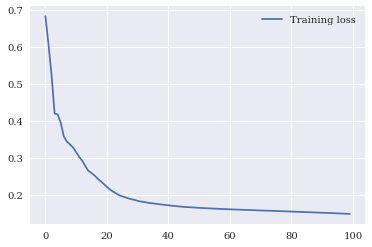

tensor([[-0.5860,  1.3808, -0.8239,  ...,  0.6001,  0.2848,  0.1973],
        [-0.5861,  1.4543, -0.8149,  ...,  0.5780,  0.2547,  0.1738],
        [-0.6240,  1.1517, -0.8288,  ...,  0.6077,  0.2866,  0.1515],
        ...,
        [-0.6073,  0.9402, -0.8244,  ...,  0.5562,  0.3349,  0.1690],
        [-0.5965,  1.0616, -0.8142,  ...,  0.5540,  0.3292,  0.1732],
        [-0.5934,  1.1327, -0.8155,  ...,  0.5504,  0.3165,  0.1696]],
       grad_fn=<AddmmBackward>)
Train Score: 2.83 RMSE
Test Score: 3.63 RMSE
(197,)


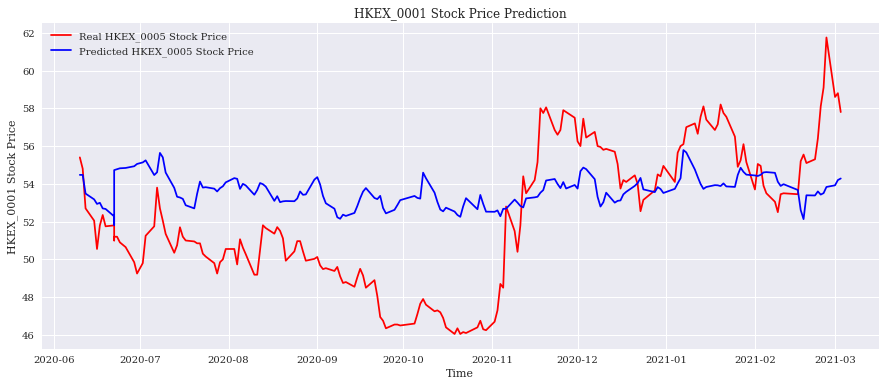

[0, 0, 0, -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
def starter(ticker):
    input_dim,hidden_dim,num_layers,output_dim=set_parameter()
    df=merge_data(ticker)
    # print(df)
    # visualization_data(df)
    scaled,scaler=data_preprocess(df)
    
    # choose sequence length
    look_back = 60
    x_train, y_train, x_test, y_test = load_data(scaled, look_back)
    # make training and test sets in torch
    x_train, y_train, x_test, y_test = data_to_torch(x_train,y_train,x_test,y_test)

    n_steps = look_back-1

    num_epochs = 100 #n_iters / (len(train_X) / batch_size)
    input_dim,hidden_dim,num_layers,output_dim=set_parameter()
    # create model
    model,loss_fn,optimiser=create_model(x_train,y_train,x_test,y_test,input_dim,hidden_dim,num_layers,output_dim)
    #  check dimensions
    # print(model)
    # print(len(list(model.parameters())))
    # for i in range(len(list(model.parameters()))):
    #     print(list(model.parameters())[i].size())

    # trained the model
    y_train_pred=train_model(x_train,y_train,num_epochs,look_back,model,loss_fn,optimiser)

     # get the predicted output
    y_train_pred,y_test_pred,y_train,y_test =predict(x_test,y_train_pred,y_train,y_test,model,scaler)

    # visualize the result
    visualization(df,y_test[:,0],y_test_pred[:,0])
    #generating signal
    signal=generate_signal(y_test_pred[:,0],y_test[:,0])
    print(signal)

starter('1')






    
            